## ライブラリのインポート　ファイルの読み込み

In [ ]:
!pip install -q japanize-matplotlib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from google.colab import drive
import japanize_matplotlib
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np


drive.mount('/content/drive')
%cd drive/MyDrive/handson_jleague

# データを表示する時に列を省略しないためのおまじない
pd.options.display.max_columns=None

%matplotlib inline

# #日本語化matplotlibのインポート & 日本語のフォントを指定
plt.rcParams['font.family'] = 'IPAexGothic'

# データの読み込み
train = pd.read_csv("./data/train_all.csv")
test = pd.read_csv("./data/test_all.csv")
sample = pd.read_csv("./data/sample_submit.csv",header=None)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Mounted at /content/drive
/content/drive/MyDrive/handson_jleague


## 特徴量

In [ ]:
#月、日、曜日を取り出す
train['MONTH']=train['gameday'].apply(lambda x: int(x[0:2]))
train["MONTH"] = train["MONTH"].astype(int)
train['day']=train['gameday'].apply(lambda x: int(x[3:5]))
train["WEEK"] = train["gameday"].apply(lambda x : x[x.find("(")+1:x.find("(")+2])
#テストデータも同様に
test['MONTH']=test['gameday'].apply(lambda x: int(x[:2]))
test["MONTH"] = test["MONTH"].astype(int)
test['day']=test['gameday'].apply(lambda x: int(x[3:5]))
test["WEEK"] = test["gameday"].apply(lambda x : x[x.find("(")+1:x.find("(")+2])

# 第１節などのカラムから数字を取り出してmatch_numに入れる
train['match_num']=train['match'].apply(lambda x: int(x[x.find("第")+1: x.find("節")]))
test['match_num']=test['match'].apply(lambda x: int(x[x.find("第")+1: x.find("節")]))

#不要カラムの削除
train=train.drop(columns=['gameday','match'])
test=test.drop(columns=['gameday','match'])

In [ ]:
train["tv_num"] = train["tv"].apply(lambda x : len(x.split("／")))
test["tv_num"] = test["tv"].apply(lambda x : len(x.split("／")))

In [ ]:
# 結合前にtrainというフラグを作り、trainデータは1、testデータは0とする
train["train"]=1
test["train"]=0

# 結合、但し、trainでyが0以上のものだけを選択
dat = pd.concat([train[train["y"]>0],test],sort=False)

select_cols = ["capa","MONTH","WEEK","stage","home","tv_num","train"]
datX = pd.get_dummies(dat[select_cols],drop_first=True)

# datXにおいてtrainフラグが1のものをtrainXとする。その後、trainフラグを削除
trainX = datX[datX["train"]==1]
trainX = trainX.drop(columns="train")

# datXにおいてtrainフラグが0のものをtestXとする。その後、trainフラグを削除
testX = datX[datX["train"]==0]
testX = testX.drop(columns="train")

# y>0のものだけを選択
y = train[train["y"]>0]["y"]

In [ ]:
# 予測に使用しているカラムの確認
trainX.columns

Index(['capa', 'MONTH', 'tv_num', 'WEEK_日', 'WEEK_月', 'WEEK_木', 'WEEK_水',
       'WEEK_火', 'WEEK_金', 'stage_Ｊ２', 'home_アルビレックス新潟', 'home_カターレ富山',
       'home_カマタマーレ讃岐', 'home_ガイナーレ鳥取', 'home_ガンバ大阪', 'home_ギラヴァンツ北九州',
       'home_コンサドーレ札幌', 'home_サガン鳥栖', 'home_サンフレッチェ広島', 'home_ザスパクサツ群馬',
       'home_ザスパ草津', 'home_ジェフユナイテッド千葉', 'home_ジュビロ磐田', 'home_セレッソ大阪',
       'home_ファジアーノ岡山', 'home_ベガルタ仙台', 'home_モンテディオ山形', 'home_ロアッソ熊本',
       'home_ヴァンフォーレ甲府', 'home_ヴィッセル神戸', 'home_京都サンガF.C.', 'home_名古屋グランパス',
       'home_大分トリニータ', 'home_大宮アルディージャ', 'home_川崎フロンターレ', 'home_徳島ヴォルティス',
       'home_愛媛ＦＣ', 'home_東京ヴェルディ', 'home_松本山雅ＦＣ', 'home_柏レイソル', 'home_栃木ＳＣ',
       'home_横浜Ｆ・マリノス', 'home_横浜ＦＣ', 'home_水戸ホーリーホック', 'home_浦和レッズ',
       'home_清水エスパルス', 'home_湘南ベルマーレ', 'home_鹿島アントラーズ', 'home_ＦＣ岐阜',
       'home_ＦＣ東京', 'home_ＦＣ町田ゼルビア', 'home_Ｖ・ファーレン長崎'],
      dtype='object')

## トレーニングデータを分割

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(trainX, y, random_state=0)

# Linear Regression

## 動員数予測

In [ ]:
lr_model = LR()
lr_model.fit(trainX,y)

LinearRegression()

In [ ]:
pred = lr_model.predict(trainX) # trainデータで学習したモデルでtrainデータを予測

# 予測値の最小値が学習データ中のyの最小値よりも小さかったら、学習データの最小値で置換
min_values = train[train["y"]>0]["y"].min()
pred[pred<min_values] = min_values

# sklearnではRMSEはなく、MSEしかないので一旦、MSEを算出
mse = MSE(pred,y)
# MSEにルートを取ったものがRMSEなので、mseに0.5乗して求める
rmse = mse**0.5
rmse

3448.123287159402

In [ ]:
# testデータの予測
lr_test_pred = lr_model.predict(testX)

# 予測値の最小値が学習データ中のyの最小値よりも小さかったら、学習データの最小値で置換
lr_test_pred[lr_test_pred<min_values] = min_values

sample[1] = lr_test_pred
sample.to_csv("./model/LR_test.csv",index=None,header=None)

## 動員率予測

In [ ]:
# 無観客試合を除外
train = train[train["y"] > 0]

# 動員率の計算
train["attendance_rate"] = train["y"] / train["capa"]

y_rate = train["attendance_rate"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(trainX, y_rate, random_state=0)

# モデルの構築と学習
lr_model = LR()
lr_model.fit(X_train, y_train)

# 予測（学習データとテストデータ）
pred_train_rate = lr_model.predict(X_train)
pred_test_rate = lr_model.predict(X_test)

# 予測値の最小値が動員率の最小値よりも小さかった場合、最小値で置換
min_rate = train["attendance_rate"].min()
pred_train_rate[pred_train_rate < min_rate] = min_rate
pred_test_rate[pred_test_rate < min_rate] = min_rate

# MSEを算出（学習データとテストデータで評価）
mse_train = MSE(y_train, pred_train_rate)
mse_test = MSE(y_test, pred_test_rate)

# RMSEを計算
# RMSEを算出
rmse_train = mse_train ** 0.5
rmse_test = mse_test ** 0.5

print(f"Train RMSE: {rmse_train}")
print(f"Test RMSE: {rmse_test}")

Train RMSE: 0.11577631776793204
Test RMSE: 0.12654587848425777


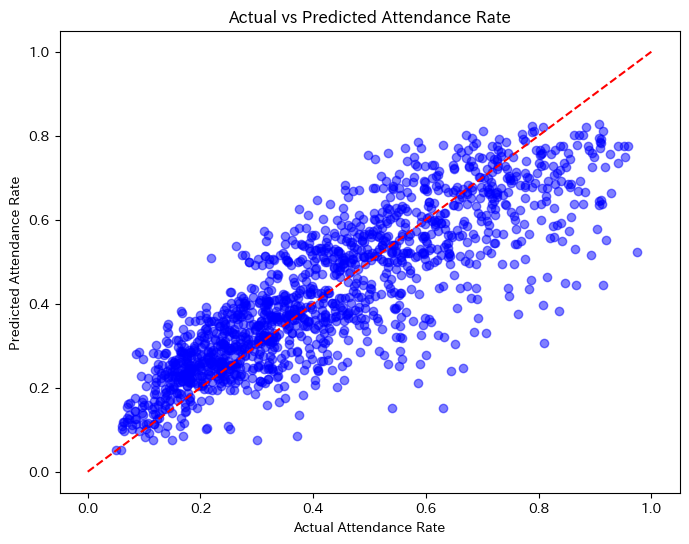

In [ ]:
import matplotlib.pyplot as plt

# 散布図の作成
plt.figure(figsize=(8, 6))
plt.scatter(y_train, pred_train_rate, alpha=0.5, color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # 予測と実際が一致するライン
plt.title('Actual vs Predicted Attendance Rate')
plt.xlabel('Actual Attendance Rate')
plt.ylabel('Predicted Attendance Rate')
plt.show()


In [ ]:
# 動員数→動員数を計算
# pred_rate: 動員率の予測結果
# testX["capa"]: 各試合の収容人数

#投稿用データの予測
lr_test_pred_rate = lr_model.predict(testX)

pred_attendance = lr_test_pred_rate  * testX["capa"]

# 動員数を整数に丸める（必要に応じて）
pred_attendance = pred_attendance.round().astype(int)

# 結果の確認
print(pred_attendance)

sample[1]=pred_attendance
sample.to_csv('./model/LR_model_rate.csv' ,header=None, index=False)


0      15460
1      15746
2      38802
3      12185
4      25434
       ...  
308     5403
309     8795
310     3586
311     6632
312    10997
Name: capa, Length: 313, dtype: int64


## 動員率と動員数予測の平均を取る

In [ ]:
# 動員率からの予測値と動員数からの予測値の平均を計算
average_pred = (pred_attendance + lr_test_pred) / 2

sample[1]=average_pred
sample.to_csv('./model/LR_model_average.csv' ,header=None, index=False)

# Random Forest

## 動員数

In [ ]:
# ランダムフォレストの初期モデル
rf = RandomForestClassifier(random_state=0)

# 探索するパラメータの候補
param_grid = {
    'n_estimators': [50, 100, 200],         # 決定木の本数
    'max_depth': [10, 20, 30],              # 決定木の深さ
    'min_samples_leaf': [1, 5, 10],         # 葉ノードの最小サンプル数
    'min_samples_split': [2, 5, 10],        # 分割に必要な最小サンプル数
}

# グリッドサーチの設定
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# 探索の実行
grid_search.fit(X_train, y_train)

# 最適なパラメータの確認
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# 最適なモデルでテストデータを予測
rf_model = grid_search.best_estimator_
test_score = rf_model.score(X_test, y_test)
print("Test Set Accuracy:", test_score)


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best Parameters: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: 0.0020491803278688526
Test Set Accuracy: 0.0


In [ ]:
rf_pred = rf_model.predict(trainX)

# 予測値の最小値が学習データ中のyの最小値よりも小さかったら、学習データの最小値で置換
min_values = train[train["y"]>0]["y"].min()
rf_pred[ rf_pred < min_values ] = min_values

# sklearnではRMSEはなく、MSEしかないので一旦、MSEを算出
rf_mse = MSE(rf_pred,y)
# MSEにルートを取ったものがRMSEなので、mseに0.5乗して求める
rf_rmse = rf_mse**0.5
rf_rmse

3583.49093192955

In [ ]:
# テストデータの予測と予測結果の保存
rf_test_pred = rf_model.predict(testX)

# 予測値の最小値が学習データ中のyの最小値よりも小さかったら、学習データの最小値で置換
rf_test_pred[rf_test_pred<min_values] = min_values

sample[1] = rf_test_pred
sample.to_csv("./model/RF_test2.csv",index=None,header=None)

# LightGBM

## 動員数

In [ ]:
# LightGBM用のデータセットに変換
lg_train = lgb.Dataset(X_train, y_train)
lg_evaluation = lgb.Dataset(X_test, y_test, reference=lg_train)

# パラメータ探索の範囲を設定
param_grid = {
    'objective': ['regression'],
    'metric': ['rmse'],
    'boosting_type': ['gbdt'],  # GBDT（Gradient Boosting Decision Tree）
    'learning_rate': [0.05, 0.1],   # 学習率
    'num_leaves': [31, 50, 100],        # リーフの数
    'max_depth': [-1, 10, 20],         # 木の深さ
    'min_child_samples': [20, 30], # 最小データ数
    'subsample': [0.8, 1.0],        # データのサブサンプリング
    'colsample_bytree': [0.8, 1.0], # 特徴量のサブサンプリング
    'reg_alpha': [0.0, 0.1],        # L1正則化
    'reg_lambda': [0.0, 0.1]        # L2正則化
}

# グリッドサーチ設定
grid_search = GridSearchCV(estimator=lgb.LGBMRegressor(),
                           param_grid=param_grid,
                           cv=5,                # 5分割のクロスバリデーション
                           scoring='neg_mean_squared_error',  # MSEを最小化する
                           n_jobs=-1,
                           verbose=1)

# グリッドサーチ実行
grid_search.fit(X_train, y_train)

# 最適なパラメータを表示
print("Best Parameters:", grid_search.best_params_)

# 最良のモデルを取得
lg_model = grid_search.best_estimator_

# 予測の実行
lg_pred = lg_model.predict(X_test)

# RMSEを計算（MSEからRMSEに変換）
lg_mse = MSE(y_test, lg_pred)
lg_rmse = np.sqrt(lg_mse)

# RMSEを表示
print("Best RMSE:", lg_rmse)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 1464, number of used features: 48
[LightGBM] [Info] Start training from score 10693.200820
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

             feature  importance
0               capa        1033
1              MONTH         611
2             tv_num         303
3             WEEK_日         121
9           stage_Ｊ２          76
6             WEEK_水          60
44        home_浦和レッズ          45
18    home_サンフレッチェ広島          33
31     home_名古屋グランパス          32
38       home_松本山雅ＦＣ          29
25       home_ベガルタ仙台          28
39        home_柏レイソル          27
24     home_ファジアーノ岡山          27
4             WEEK_月          26
23       home_セレッソ大阪          26
28    home_ヴァンフォーレ甲府          25
16     home_コンサドーレ札幌          23
14        home_ガンバ大阪          23
27       home_ロアッソ熊本          23
7             WEEK_火          23
22       home_ジュビロ磐田          21
32      home_大分トリニータ          21
8             WEEK_金          19
49         home_ＦＣ東京          19
46      home_湘南ベルマーレ          18
29      home_ヴィッセル神戸          17
45      home_清水エスパルス          17
37      home_東京ヴェルディ          16
33    home_大宮アルディージャ          14
21  home_ジ

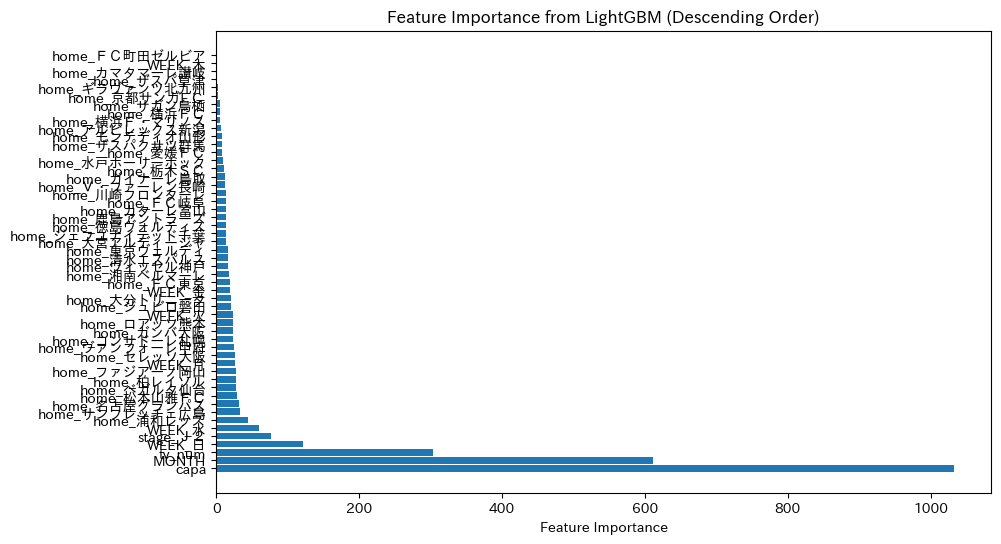

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 特徴量の重要度を取得
importances = lg_model.feature_importances_

# 特徴量の名前を取得（X_trainのカラム名）
features = X_train.columns

# DataFrameに変換して、特徴量とその重要度を結びつける
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
})

# 重要度で降順に並べ替え
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 上位の特徴量を表示
print(feature_importance_df)

# 重要度順にプロット
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from LightGBM (Descending Order)')
plt.show()


In [ ]:
#投稿用データの予測
lg_test_pred = lg_model.predict(testX)

sample[1]=lg_test_pred
sample.to_csv('./model/LG_model.csv' ,header=None, index=False)

## 動員率

In [ ]:
# 無観客試合を除外
train = train[train["y"] > 0]

# 動員率の計算
train["attendance_rate"] = train["y"] / train["capa"]

y_rate = train["attendance_rate"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(trainX, y_rate, random_state=0)

# LightGBM用のデータセットに変換
lg_train = lgb.Dataset(X_train, y_train)
lg_evaluation = lgb.Dataset(X_test, y_test, reference=lg_train)

# パラメータ探索の範囲を設定
param_grid = {
    'objective': ['regression'],
    'metric': ['rmse'],
    'boosting_type': ['gbdt'],  # GBDT（Gradient Boosting Decision Tree）
    'learning_rate': [0.05, 0.1],   # 学習率
    'num_leaves': [31, 50, 100],        # リーフの数
    'max_depth': [-1, 10, 20],         # 木の深さ
    'min_child_samples': [20, 30], # 最小データ数
    'subsample': [0.8, 1.0],        # データのサブサンプリング
    'colsample_bytree': [0.8, 1.0], # 特徴量のサブサンプリング
    'reg_alpha': [0.0, 0.1],        # L1正則化
    'reg_lambda': [0.0, 0.1]        # L2正則化
}

# グリッドサーチ設定
grid_search = GridSearchCV(estimator=lgb.LGBMRegressor(),
                           param_grid=param_grid,
                           cv=5,                # 5分割のクロスバリデーション
                           scoring='neg_mean_squared_error',  # MSEを最小化する
                           n_jobs=-1,
                           verbose=1)

# グリッドサーチ実行
grid_search.fit(X_train, y_train)

# 最適なパラメータを表示
print("Best Parameters:", grid_search.best_params_)

# 最良のモデルを取得
lg_model = grid_search.best_estimator_

# 予測の実行
lg_pred = lg_model.predict(X_test)

# RMSEを計算（MSEからRMSEに変換）
lg_mse = MSE(y_test, lg_pred)
lg_rmse = np.sqrt(lg_mse)

# RMSEを表示
print("Best RMSE:", lg_rmse)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


<ipython-input-7-e4608c85efda>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["attendance_rate"] = train["y"] / train["capa"]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 1464, number of used features: 48
[LightGBM] [Info] Start training from score 0.423222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:
# 動員数→動員数を計算
# pred_rate: 動員率の予測結果
# testX["capa"]: 各試合の収容人数

#投稿用データの予測
lg_test_pred_rate = lg_model.predict(testX)

pred_attendance = lg_test_pred_rate  * testX["capa"]

# 動員数を整数に丸める（必要に応じて）
pred_attendance = pred_attendance.round().astype(int)

sample[1]=pred_attendance
sample.to_csv('./model/LG_model_rate.csv' ,header=None, index=False)